In [1]:

import sqlite3
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter


def trim_start_end_nans(df):
    """
    Removes rows at the start and end of a DataFrame that have NaN values in any column.
    """
    # Initialize start_idx and end_idx based on the DataFrame's index type
    if isinstance(df.index, pd.DatetimeIndex):
        start_idx = df.index[0]  # Assume first index is earliest; adjust if necessary
        end_idx = df.index[-1]  # Assume last index is latest; adjust if necessary
    else:
        start_idx = 0
        end_idx = len(df) - 1

    for column in df.columns:
        # Find the first non-NaN index in the current column
        first_valid_index = df[column].first_valid_index()
        if first_valid_index is not None and df.index.get_loc(first_valid_index) > df.index.get_loc(start_idx):
            start_idx = first_valid_index

        # Find the last non-NaN index in the current column
        last_valid_index = df[column].last_valid_index()
        if last_valid_index is not None and df.index.get_loc(last_valid_index) < df.index.get_loc(end_idx):
            end_idx = last_valid_index

    # Trim the DataFrame
    return df.loc[start_idx:end_idx]

# Now, apply the updated function to the DataFrame

def process_data_for_plot(plot_number, start_date='2023-07-20', end_date='2023-09-03'):
    """
    Process data for a given plot number within a specified date range.

    Parameters:
    - plot_number: The plot number to filter the data by.
    - start_date: The start date of the period to filter the data.
    - end_date: The end date of the period to filter the data.

    Returns:
    - A processed DataFrame with the data for the specified plot and date range.
    """
    # Connect to the database and load data
    conn = sqlite3.connect('processed_data.db')
    query = 'SELECT * from data_table'
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Filter by plot_number
    df = df[df['plot_number'] == plot_number]

    # Filter by date range
    df = df[(df['TIMESTAMP'] >= start_date) & (df['TIMESTAMP'] <= end_date)]

    # Timestamp cyclical encoding
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df['day_sin'] = np.sin(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['day_cos'] = np.cos(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['hour_sin'] = np.sin(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
    df['hour_cos'] = np.cos(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
    df['dow_sin'] = np.sin(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)
    df['dow_cos'] = np.cos(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)

    # Define columns for processing
    time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

    # Columns for correlation matrix
    corr_columns = [
        'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 
        'Dp_2m_Avg', 'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg', 
        'canopy_temp', 'VWC_06', 'VWC_18', 'VWC_30', 
        'daily_et', 'CWSI', 'SWSI', 'precip_irrig'
    ]

    # Eliminate duplicate indices and set TIMESTAMP as index
    df = df.drop_duplicates().set_index('TIMESTAMP').sort_index()

    # Assuming trim_start_end_nans is a predefined function to handle NaN values
    df = trim_start_end_nans(df)

    # Interpolate missing values
    df = df[corr_columns + time_columns].interpolate(method='pchip')
    
    # run savgol filter with no differentiation an window = 10 to target columns
    target_columns = ['VWC_06', 'VWC_18', 'VWC_30']
    for column in target_columns:
        df[column] = savgol_filter(x=df[column], window_length=20, polyorder=4, deriv=0)
        
    # testing different transforms
    #df['precip_irrig'] = df['precip_irrig'].apply(lambda x: np.log(x) if x > 0 else 0)
    df['precip_irrig_log'] = np.log(df['precip_irrig'] + 1)
    

    return df



In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2 
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import json

# Check TensorFlow GPU availability
if tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None):
    print("TensorFlow will use the GPU!")
else:
    print("TensorFlow cannot find a GPU!")



def subtract_mean(df, target_columns):
    mean_values = {}
    for col in target_columns:
        mean_value = df[col].mean()  
        df[col] -= mean_value
        mean_values[col] = mean_value
    return df, mean_values



def create_derivative_columns(df, target_columns, keep_original_cols=True):
    """Calculates difference-based derivatives of specified columns.

    Args:
        df: Pandas DataFrame containing the data.
        target_columns: List of columns for which derivatives are calculated.
        keep_original_cols: If True, creates new columns; otherwise overwrites.

    Returns:
        DataFrame with derivative columns, plus initial values if needed.
    """

    initial_values = {}  # Store initial values for reconstruction

    for col in target_columns:
        deriv_col_name = f"{col}_deriv"

        if keep_original_cols:
            df[deriv_col_name] = df[col].diff()  # Calculate differences
            
            #  #Plot the original and derived columns
            # plt.figure(figsize=(10, 6))
            # plt.plot(df[col], label=col)
            # plt.plot(df[deriv_col_name], label=deriv_col_name)
            # plt.xlabel('Time')
            # plt.ylabel('Value')
            # plt.title(f'{col} vs {deriv_col_name}')
            # plt.legend()
            # plt.show()
            
        else:
            initial_values[col] = df[col].iloc[0]  # Store initial value
            df[col] = df[col].diff()  
            

    return df, initial_values  # Return initial values as well

def scale_dataframe(df, scalers):
    """
    Optimally scale all columns in a DataFrame using MinMaxScaler, adjusting for an expanded range with a buffer. 
    This involves creating a dummy range for scaler fitting, then scaling the original data with the adjusted scaler.

    Args:
        df (pd.DataFrame): DataFrame with columns to be scaled.
        scalers (dict): Dictionary storing the scalers for each column.

    Returns:
        pd.DataFrame: Scaled DataFrame using the optimally adjusted scalers.
        dict: Dictionary of the adjusted scalers.
    """
    scaled_df = pd.DataFrame()  # Initialize an empty DataFrame for scaled values
    for column in df.columns:
        # Check if a scaler already exists; if not, proceed to create and fit a new one
        if column not in scalers:
            # Calculate the original range and apply a 30% buffer
            col_min, col_max = df[column].min(), df[column].max()
            range_buffer = (col_max - col_min) * 0.3  # 30% buffer
            buffered_min = col_min - range_buffer
            buffered_max = col_max + range_buffer

            # Create a new scaler and fit it on the buffered range
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaler.fit([[buffered_min], [buffered_max]])
            scalers[column] = scaler

        # Scale the original data with the adjusted scaler
        scaled_values = scalers[column].transform(df[[column]].values.reshape(-1, 1)).flatten()  # Flatten the array here
        scaled_df[column] = scaled_values


    return scaled_df, scalers


def transform_and_scale_data(df, target_columns, scalers, keep_original_cols=True):
    """
    Transforms and scales the data in the DataFrame for neural network input, returning the
    transformed DataFrame, updated scalers, and transformation metadata.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_columns (list): List of target column names.
        scalers (dict): Dictionary containing MinMaxScalers for each column, can be empty.
        keep_original_cols (bool): If True, keeps original columns unchanged except for scaling;
                                   if False, applies transformations directly on the target columns.

    Returns:
        pd.DataFrame: The transformed and scaled DataFrame.
        dict: Updated dictionary containing MinMaxScalers for each column.
        dict: A dictionary containing transformation metadata for the target columns.
    """

    # Copy DataFrame to avoid modifying the original
    df_transformed = df.copy()

    
    # Subtract mean from target columns
    df_transformed, mean_values = subtract_mean(df_transformed, target_columns)
    
    # Apply transformations directly using helper functions
    df_transformed, initial_values = create_derivative_columns(df_transformed, target_columns, keep_original_cols)
    
    # Deleting or adjusting rows as necessary (e.g., due to NaN values from differentiation)
    df_transformed = df_transformed.iloc[1:]
    
    # Scale all columns in df_transformed
    df_transformed, scalers = scale_dataframe(df_transformed, scalers)
    
    print(f"Shape of transformed DataFrame: {df_transformed.shape}")
    
    # Metadata for reverse transformation
    transformation_metadata = {
        'means': mean_values,
        'scalers': scalers,
        'keep_original_cols': keep_original_cols,
        'initial_values': initial_values
    }
    
    # add 'precip_irrig_bool' as a binned column with 0 or 1
    df_transformed['precip_irrig_bool'] = df_transformed['precip_irrig_log'].apply(lambda x: 1 if x > 0 else 0)
    
    # Metadata for reverse transformation
    transformation_metadata = {
        'means': mean_values,
        'scalers': scalers,
        'keep_original_cols': keep_original_cols,
        'initial_values': initial_values,
        'columns': df.columns.tolist()
    }
    


    return df_transformed, transformation_metadata



def reverse_transform_and_scale_data(df, transformation_metadata, target_columns):
    """
    Reverses the transformations and scaling applied to the DataFrame.

    Args:
        df (pd.DataFrame): The transformed and scaled DataFrame.
        transformation_metadata (dict): A dictionary containing transformation metadata.
        target_columns (list): List of target columns to be reverse transformed and scaled.

    Returns:
        pd.DataFrame: The DataFrame with reversed transformations and scaling.
    """

    # Extract metadata
    scalers = transformation_metadata['scalers']
    mean_values = transformation_metadata['means']
    initial_values = transformation_metadata['initial_values']
    keep_original_cols = transformation_metadata['keep_original_cols']

    # Print dimensions of df
    print(f"Shape of input DataFrame: {df.shape}")

    # Reverse scale the target columns
    for column in target_columns:
        if column in scalers:
            # Reshape data for inverse_transform
            scaled_data = df[[column]].values
            # Apply inverse_transform
            df[column] = scalers[column].inverse_transform(scaled_data)

    # Apply undifferencing with cumsum() 
    for column in target_columns:
        # Reverse subtract mean from target columns if they were mean-adjusted
        if column in mean_values:
            print(f"Mean for {column}: ", mean_values[column])
            df[column] = df[column] + mean_values[column]
            print(f"Reversed mean for {column}: ", df[column].head())


    return df




# Sequence Creation Function
def create_sequences(input_data, target_data, input_window, forecast_horizon, stride=1):
    X, y = [], []
    for start in range(len(input_data) - input_window - forecast_horizon + stride):
        end = start + input_window
        X.append(input_data[start:end])
        y.append(target_data[end:end + forecast_horizon])
    return np.array(X), np.array(y)


def build_model(input_shape, num_targets):
    model = Sequential([
        LSTM(256, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.02)), 
        BatchNormalization(),
        Dropout(0.2),
        LSTM(128, return_sequences=True),  
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),  
        BatchNormalization(),
        Dropout(0.1),
        LSTM(64, return_sequences=True),  
        BatchNormalization(),
        Dropout(0.1),
        LSTM(32, return_sequences=False),
        Dense(96 * num_targets), 
        Reshape((96, num_targets)) 
    ])
    model.compile(optimizer='adam', loss='mse')
    return model



def chronological_split(X, y, test_size=0.2):
    # Calculate the index to split the data
    total_samples = len(X)
    split_index = int(total_samples * (1 - test_size))
    
    # Split the data chronologically
    X_train = X[:split_index]
    X_val = X[split_index:]
    y_train = y[:split_index]
    y_val = y[split_index:]
    
    return X_train, X_val, y_train, y_val

# Learning Rate Scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create a LearningRateScheduler callback
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)



# Define the training step
@tf.function()
def train_step(model, optimizer, loss_function, x_batch, y_batch):
    with tf.GradientTape() as tape:
        predictions = model(x_batch, training=True)
        loss = loss_function(y_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Define the validation step
@tf.function()
def val_step(model, loss_function, x_batch, y_batch):
    predictions = model(x_batch, training=False)
    loss = loss_function(y_batch, predictions)
    return loss

def run_workflow(training_data_transformed, target_variables, input_window, forecast_horizon, stride, epochs, batch_size, patience, checkpoint_path):
    X_train_all, X_val_all, y_train_all, y_val_all = [], [], [], []
    dataframe_identifiers = []
    n_splits = 5  # Define the number of splits for cross-validation

    # Data preparation
    for i, transformed_data in enumerate(training_data_transformed()):
        df = transformed_data[0]
        X, y = create_sequences(df.values, df[target_variables].values, input_window, forecast_horizon, stride)
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        for fold, (train_index, val_index) in enumerate(tscv.split(X)):
            print(f"Processing fold {fold+1}/{n_splits} for DataFrame_{i}")
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            X_train_all.append(X_train)
            X_val_all.append(X_val)
            y_train_all.append(y_train)
            y_val_all.append(y_val)
        
        dataframe_identifiers.append(f"DataFrame_{i}")

    # Model and training setup
    model = build_model((input_window, X_train_all[0].shape[2]), len(target_variables))
    optimizer = tf.keras.optimizers.Adam()
    loss_function = tf.keras.losses.MeanSquaredError()
    best_val_loss = np.inf

    # Training and validation
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_val_losses = []

        for fold in range(n_splits):
            print(f"Training on fold {fold + 1}/{n_splits}")
            X_train, y_train = X_train_all[fold], y_train_all[fold]

            dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

            for x_batch, y_batch in dataset:
                train_step(model, optimizer, loss_function, x_batch, y_batch)

            # Validation
            X_val, y_val = X_val_all[fold], y_val_all[fold]
            val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
            val_losses = []
            for x_batch, y_batch in val_dataset:
                val_loss = val_step(model, loss_function, x_batch, y_batch)
                val_losses.append(val_loss.numpy())

            avg_val_loss = np.mean(val_losses)
            epoch_val_losses.append(avg_val_loss)
            print(f"Validation loss for fold {fold+1}/{n_splits}: {avg_val_loss}")

        # Average validation loss across folds
        average_val_loss = np.mean(epoch_val_losses)
        print(f"Average validation loss for epoch {epoch+1}: {average_val_loss}")

        # Early stopping and model saving logic
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            model.save(checkpoint_path)
            print(f"Model saved at epoch {epoch+1} with validation loss: {average_val_loss}")
            wait = 0  # Reset wait counter after improvement
        else:
            wait += 1
            if wait >= patience:
                print(f"Stopping early due to no improvement in validation loss for {patience} epochs.")
                break

    return checkpoint_path




# Example Usage
plot_numbers = [2014, 2015, 2007]#, 2001]


# Initialize a scaler
scalers = {}

# *** Important: Update the target_columns and continuous_columns based on your chosen target columns ***
# *** Any columns included in target_columns should be removed from continuous_columns ***
target_columns = ['VWC_06', 'VWC_18', 'VWC_30']
time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
continuous_columns = [
    'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot', 'Dp_2m_Avg',
    'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg',
    'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig','canopy_temp'
]
derivative_columns = ['precip_irrig']

input_window = 168
forecast_horizon = 96
stride = 1
epochs = 8000
patience = 500
batch_size = 32  
checkpoint_path = "./LSTM"



# Set to True to keep original columns unchanged
keep_original_cols=True


# Lambda function to handle training data and plot numbers
training_data_dfs = lambda: [process_data_for_plot(plot) for plot in plot_numbers]


# run once to get the transformation metadata
_, transformation_metadata = transform_and_scale_data(training_data_dfs()[0], target_columns, scalers, keep_original_cols)

# re-run with the transformation metadata for all training dataframes
training_data_transformed = lambda: [transform_and_scale_data(df, target_columns, transformation_metadata['scalers'], keep_original_cols) for df in training_data_dfs()]


    
    



# run the workflow for training the model
checkpoint_path = run_workflow(training_data_transformed, target_columns, 
                                      input_window, forecast_horizon, stride, epochs, batch_size, patience, checkpoint_path)

# run the workflow for training the model
import pickle

# Store the transformation metadata in checkpoint_path
with open(f"{checkpoint_path}/transformation_metadata1.pkl", "wb") as file:
    pickle.dump(transformation_metadata, file)




Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow cannot find a GPU!
Shape of transformed DataFrame: (820, 28)
Shape of transformed DataFrame: (820, 28)
Shape of transformed DataFrame: (1055, 28)
Shape of transformed DataFrame: (1062, 28)
Processing fold 1/5 for DataFrame_0
Processing fold 2/5 for DataFrame_0
Processing fold 3/5 for DataFrame_0
Processing fold 4/5 for DataFrame_0
Processing fold 5/5 for DataFrame_0
Processing fold 1/5 for DataFrame_1
Processing fold 2/5 for DataFrame_1
Processing fold 3/5 for DataFrame_1
Processing fold 4/5 for DataFrame_1
Processing fold 5/5 for DataFrame_1
Processing fold 1/5 for DataFrame_2
Processing fold 2/5 for DataFrame_2
Processing fold 3/5 for DataFrame_2
Processing fold 4/5 for DataFrame_2
Processing fold 5/5 for DataFrame_2
Epoch 1/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.30798906087875366
Training on fold 2/5
Validation loss for fold 2/5: 0.2554037868976593
Training on fold 3/5
Vali

INFO:tensorflow:Assets written to: ./LSTM\assets


Model saved at epoch 1 with validation loss: 0.18266209959983826
Epoch 2/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.038564011454582214
Training on fold 2/5
Validation loss for fold 2/5: 0.015138220973312855
Training on fold 3/5
Validation loss for fold 3/5: 0.01222072821110487
Training on fold 4/5
Validation loss for fold 4/5: 0.019390946254134178
Training on fold 5/5
Validation loss for fold 5/5: 0.026493920013308525
Average validation loss for epoch 2: 0.02236156538128853
INFO:tensorflow:Assets written to: ./LSTM\assets


INFO:tensorflow:Assets written to: ./LSTM\assets


Model saved at epoch 2 with validation loss: 0.02236156538128853
Epoch 3/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.018414659425616264
Training on fold 2/5
Validation loss for fold 2/5: 0.00892320740967989
Training on fold 3/5
Validation loss for fold 3/5: 0.009763178415596485
Training on fold 4/5
Validation loss for fold 4/5: 0.013812348246574402
Training on fold 5/5
Validation loss for fold 5/5: 0.02662850357592106
Average validation loss for epoch 3: 0.015508378855884075
INFO:tensorflow:Assets written to: ./LSTM\assets


INFO:tensorflow:Assets written to: ./LSTM\assets


Model saved at epoch 3 with validation loss: 0.015508378855884075
Epoch 4/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.013277637772262096
Training on fold 2/5
Validation loss for fold 2/5: 0.008454856462776661
Training on fold 3/5
Validation loss for fold 3/5: 0.010583318769931793
Training on fold 4/5
Validation loss for fold 4/5: 0.017285482957959175
Training on fold 5/5
Validation loss for fold 5/5: 0.02858845703303814
Average validation loss for epoch 4: 0.015637950971722603
Epoch 5/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.011612716130912304
Training on fold 2/5
Validation loss for fold 2/5: 0.008599836379289627
Training on fold 3/5
Validation loss for fold 3/5: 0.010864618234336376
Training on fold 4/5
Validation loss for fold 4/5: 0.017498573288321495
Training on fold 5/5
Validation loss for fold 5/5: 0.029367754235863686
Average validation loss for epoch 5: 0.015588698908686638
Epoch 6/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.0105449

INFO:tensorflow:Assets written to: ./LSTM\assets


Model saved at epoch 7 with validation loss: 0.014085243456065655
Epoch 8/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.009732815437018871
Training on fold 2/5
Validation loss for fold 2/5: 0.017419898882508278
Training on fold 3/5
Validation loss for fold 3/5: 0.02900085784494877
Training on fold 4/5
Validation loss for fold 4/5: 0.021794438362121582
Training on fold 5/5
Validation loss for fold 5/5: 0.024693233892321587
Average validation loss for epoch 8: 0.020528249442577362
Epoch 9/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.010326256044209003
Training on fold 2/5
Validation loss for fold 2/5: 0.009137192741036415
Training on fold 3/5
Validation loss for fold 3/5: 0.00993222277611494
Training on fold 4/5
Validation loss for fold 4/5: 0.013788111507892609
Training on fold 5/5
Validation loss for fold 5/5: 0.02464907430112362
Average validation loss for epoch 9: 0.013566571287810802
INFO:tensorflow:Assets written to: ./LSTM\assets


INFO:tensorflow:Assets written to: ./LSTM\assets


Model saved at epoch 9 with validation loss: 0.013566571287810802
Epoch 10/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.009328033775091171
Training on fold 2/5
Validation loss for fold 2/5: 0.009412790648639202
Training on fold 3/5
Validation loss for fold 3/5: 0.009820633567869663
Training on fold 4/5
Validation loss for fold 4/5: 0.013725328259170055
Training on fold 5/5
Validation loss for fold 5/5: 0.025678003206849098
Average validation loss for epoch 10: 0.013592958450317383
Epoch 11/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.013419527560472488
Training on fold 2/5
Validation loss for fold 2/5: 0.011854670010507107
Training on fold 3/5
Validation loss for fold 3/5: 0.009761414490640163
Training on fold 4/5
Validation loss for fold 4/5: 0.013463572598993778
Training on fold 5/5
Validation loss for fold 5/5: 0.024218039587140083
Average validation loss for epoch 11: 0.014543445780873299
Epoch 12/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.0

INFO:tensorflow:Assets written to: ./LSTM\assets


Model saved at epoch 22 with validation loss: 0.009835289791226387
Epoch 23/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.010519937612116337
Training on fold 2/5
Validation loss for fold 2/5: 0.011091209016740322
Training on fold 3/5
Validation loss for fold 3/5: 0.003916064742952585
Training on fold 4/5
Validation loss for fold 4/5: 0.011017397977411747
Training on fold 5/5
Validation loss for fold 5/5: 0.022808760404586792
Average validation loss for epoch 23: 0.0118706738576293
Epoch 24/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.021424921229481697
Training on fold 2/5
Validation loss for fold 2/5: 0.022469179704785347
Training on fold 3/5
Validation loss for fold 3/5: 0.0072481706738471985
Training on fold 4/5
Validation loss for fold 4/5: 0.013742762617766857
Training on fold 5/5
Validation loss for fold 5/5: 0.02191592939198017
Average validation loss for epoch 24: 0.01736019179224968
Epoch 25/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.037

INFO:tensorflow:Assets written to: ./LSTM\assets


Model saved at epoch 173 with validation loss: 0.009224526584148407
Epoch 174/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.005588842090219259
Training on fold 2/5
Validation loss for fold 2/5: 0.01774754375219345
Training on fold 3/5
Validation loss for fold 3/5: 0.016072267666459084
Training on fold 4/5
Validation loss for fold 4/5: 0.009197383187711239
Training on fold 5/5
Validation loss for fold 5/5: 0.023969456553459167
Average validation loss for epoch 174: 0.014515099115669727
Epoch 175/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.0038103994447737932
Training on fold 2/5
Validation loss for fold 2/5: 0.008031962439417839
Training on fold 3/5
Validation loss for fold 3/5: 0.0037505896762013435
Training on fold 4/5
Validation loss for fold 4/5: 0.008799022994935513
Training on fold 5/5
Validation loss for fold 5/5: 0.01811392791569233
Average validation loss for epoch 175: 0.00850118137896061
INFO:tensorflow:Assets written to: ./LSTM\assets


INFO:tensorflow:Assets written to: ./LSTM\assets


Model saved at epoch 175 with validation loss: 0.00850118137896061
Epoch 176/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.006251208018511534
Training on fold 2/5
Validation loss for fold 2/5: 0.021872421726584435
Training on fold 3/5
Validation loss for fold 3/5: 0.0160777997225523
Training on fold 4/5
Validation loss for fold 4/5: 0.00887781847268343
Training on fold 5/5
Validation loss for fold 5/5: 0.02849803864955902
Average validation loss for epoch 176: 0.016315456479787827
Epoch 177/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.002301508327946067
Training on fold 2/5
Validation loss for fold 2/5: 0.010311919264495373
Training on fold 3/5
Validation loss for fold 3/5: 0.004316740203648806
Training on fold 4/5
Validation loss for fold 4/5: 0.008423383347690105
Training on fold 5/5
Validation loss for fold 5/5: 0.03008621372282505
Average validation loss for epoch 177: 0.011087952181696892
Epoch 178/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.

INFO:tensorflow:Assets written to: ./LSTM\assets


Model saved at epoch 198 with validation loss: 0.008284601382911205
Epoch 199/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.005144247319549322
Training on fold 2/5
Validation loss for fold 2/5: 0.028767017647624016
Training on fold 3/5
Validation loss for fold 3/5: 0.01916475035250187
Training on fold 4/5
Validation loss for fold 4/5: 0.011149992235004902
Training on fold 5/5
Validation loss for fold 5/5: 0.027841439470648766
Average validation loss for epoch 199: 0.018413489684462547
Epoch 200/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.007067052181810141
Training on fold 2/5
Validation loss for fold 2/5: 0.011734627187252045
Training on fold 3/5
Validation loss for fold 3/5: 0.0037019681185483932
Training on fold 4/5
Validation loss for fold 4/5: 0.009450588375329971
Training on fold 5/5
Validation loss for fold 5/5: 0.018282070755958557
Average validation loss for epoch 200: 0.010047261603176594
Epoch 201/8000
Training on fold 1/5
Validation loss for fold 1

INFO:tensorflow:Assets written to: ./LSTM\assets


Model saved at epoch 228 with validation loss: 0.008256363682448864
Epoch 229/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.00604754313826561
Training on fold 2/5
Validation loss for fold 2/5: 0.017811646685004234
Training on fold 3/5
Validation loss for fold 3/5: 0.008298373781144619
Training on fold 4/5
Validation loss for fold 4/5: 0.007817871868610382
Training on fold 5/5
Validation loss for fold 5/5: 0.021304870024323463
Average validation loss for epoch 229: 0.012256060726940632
Epoch 230/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.006812118459492922
Training on fold 2/5
Validation loss for fold 2/5: 0.017198244109749794
Training on fold 3/5
Validation loss for fold 3/5: 0.010247044265270233
Training on fold 4/5
Validation loss for fold 4/5: 0.007402002811431885
Training on fold 5/5
Validation loss for fold 5/5: 0.020761528983712196
Average validation loss for epoch 230: 0.012484187260270119
Epoch 231/8000
Training on fold 1/5
Validation loss for fold 1/

INFO:tensorflow:Assets written to: ./LSTM\assets


Model saved at epoch 614 with validation loss: 0.007918725721538067
Epoch 615/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.0007548244320787489
Training on fold 2/5
Validation loss for fold 2/5: 0.007597966119647026
Training on fold 3/5
Validation loss for fold 3/5: 0.005575912073254585
Training on fold 4/5
Validation loss for fold 4/5: 0.010662364773452282
Training on fold 5/5
Validation loss for fold 5/5: 0.01565857045352459
Average validation loss for epoch 615: 0.008049927651882172
Epoch 616/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.0018331571482121944
Training on fold 2/5
Validation loss for fold 2/5: 0.008297598920762539
Training on fold 3/5
Validation loss for fold 3/5: 0.0022264444269239902
Training on fold 4/5
Validation loss for fold 4/5: 0.006845443043857813
Training on fold 5/5
Validation loss for fold 5/5: 0.01674392819404602
Average validation loss for epoch 616: 0.007189313881099224
INFO:tensorflow:Assets written to: ./LSTM\assets


INFO:tensorflow:Assets written to: ./LSTM\assets


Model saved at epoch 616 with validation loss: 0.007189313881099224
Epoch 617/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.001729644020088017
Training on fold 2/5
Validation loss for fold 2/5: 0.012603186070919037
Training on fold 3/5
Validation loss for fold 3/5: 0.007935619913041592
Training on fold 4/5
Validation loss for fold 4/5: 0.017319783568382263
Training on fold 5/5
Validation loss for fold 5/5: 0.0306246355175972
Average validation loss for epoch 617: 0.014042573980987072
Epoch 618/8000
Training on fold 1/5
Validation loss for fold 1/5: 0.0022010651882737875
Training on fold 2/5
Validation loss for fold 2/5: 0.02010790817439556
Training on fold 3/5
Validation loss for fold 3/5: 0.02125220000743866
Training on fold 4/5
Validation loss for fold 4/5: 0.01857358030974865
Training on fold 5/5
Validation loss for fold 5/5: 0.017308853566646576
Average validation loss for epoch 618: 0.015888722613453865
Epoch 619/8000
Training on fold 1/5
Validation loss for fold 1/5: 

KeyboardInterrupt: 

In [3]:
# run the workflow for training the model
import pickle

# Store the transformation metadata in checkpoint_path
with open(f"{checkpoint_path}/transformation_metadata1.pkl", "wb") as file:
    pickle.dump(transformation_metadata, file)

Processing plot number 2013
Shape of transformed DataFrame: (833, 28)
Means of the transformed data
Ta_2m_Avg            0.514028
RH_2m_Avg            0.561025
Solar_2m_Avg         0.368935
WndAveSpd_3m         0.373158
Dp_2m_Avg            0.540345
TaMax_2m             0.514284
TaMin_2m             0.513267
RHMax_2m             0.563949
RHMin_2m             0.558389
HeatIndex_2m_Avg     0.535314
canopy_temp          0.514868
VWC_06               0.533397
VWC_18               0.466073
VWC_30               0.433098
daily_et             0.370864
CWSI                 0.483845
SWSI                 0.503080
precip_irrig         0.191979
day_sin              0.573683
day_cos              0.378254
hour_sin             0.496685
hour_cos             0.500888
dow_sin              0.495970
dow_cos              0.480424
precip_irrig_log     0.195014
VWC_06_deriv         0.355560
VWC_18_deriv         0.311325
VWC_30_deriv         0.337294
precip_irrig_bool    1.000000
dtype: float64
1/1 [==========

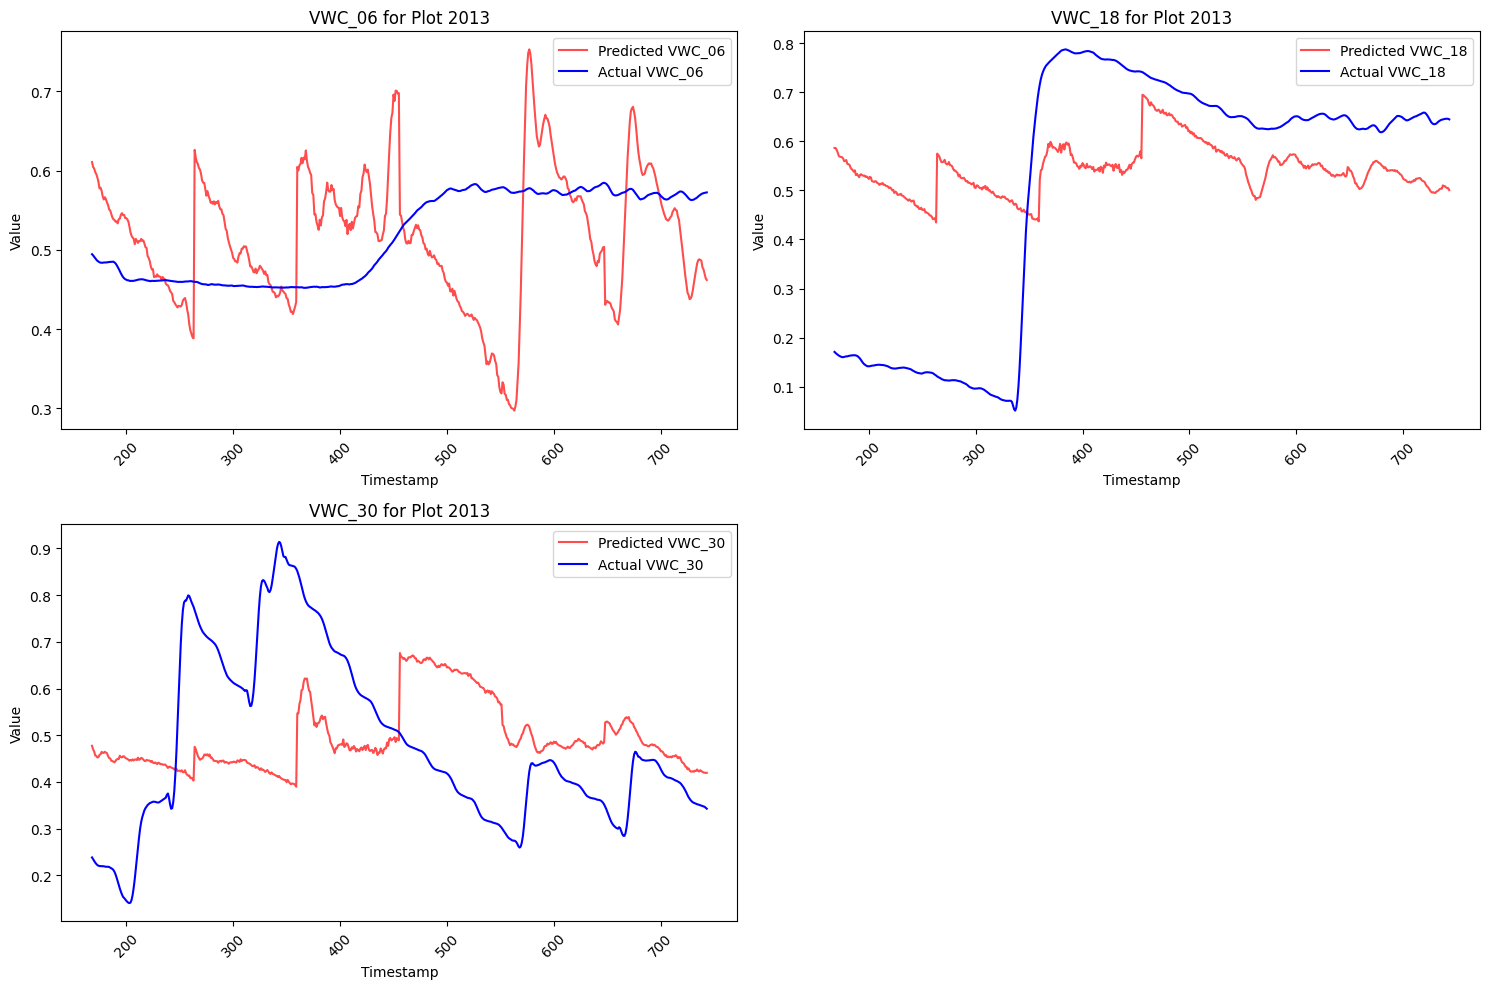

Shape of input DataFrame: (576, 3)
Mean for VWC_06:  17.820361585349556
Reversed mean for VWC_06:  168    18.797558
169    18.719418
170    18.693485
171    18.637545
172    18.604961
Name: VWC_06, dtype: float32
Mean for VWC_18:  18.113769235404764
Reversed mean for VWC_18:  168    19.459984
169    19.460138
170    19.416651
171    19.357391
172    19.279793
Name: VWC_18, dtype: float32
Mean for VWC_30:  22.610070112912528
Reversed mean for VWC_30:  168    23.131231
169    23.042765
170    22.989775
171    22.887533
172    22.877649
Name: VWC_30, dtype: float32
Shape of input DataFrame: (576, 3)
Mean for VWC_06:  17.820361585349556
Reversed mean for VWC_06:  168    17.325695
169    17.307639
170    17.284199
171    17.260483
172    17.239968
Name: VWC_06, dtype: float64
Mean for VWC_18:  18.113769235404764
Reversed mean for VWC_18:  168    14.818646
169    14.795986
170    14.771826
171    14.755425
172    14.735107
Name: VWC_18, dtype: float64
Mean for VWC_30:  22.610070112912528
Rev

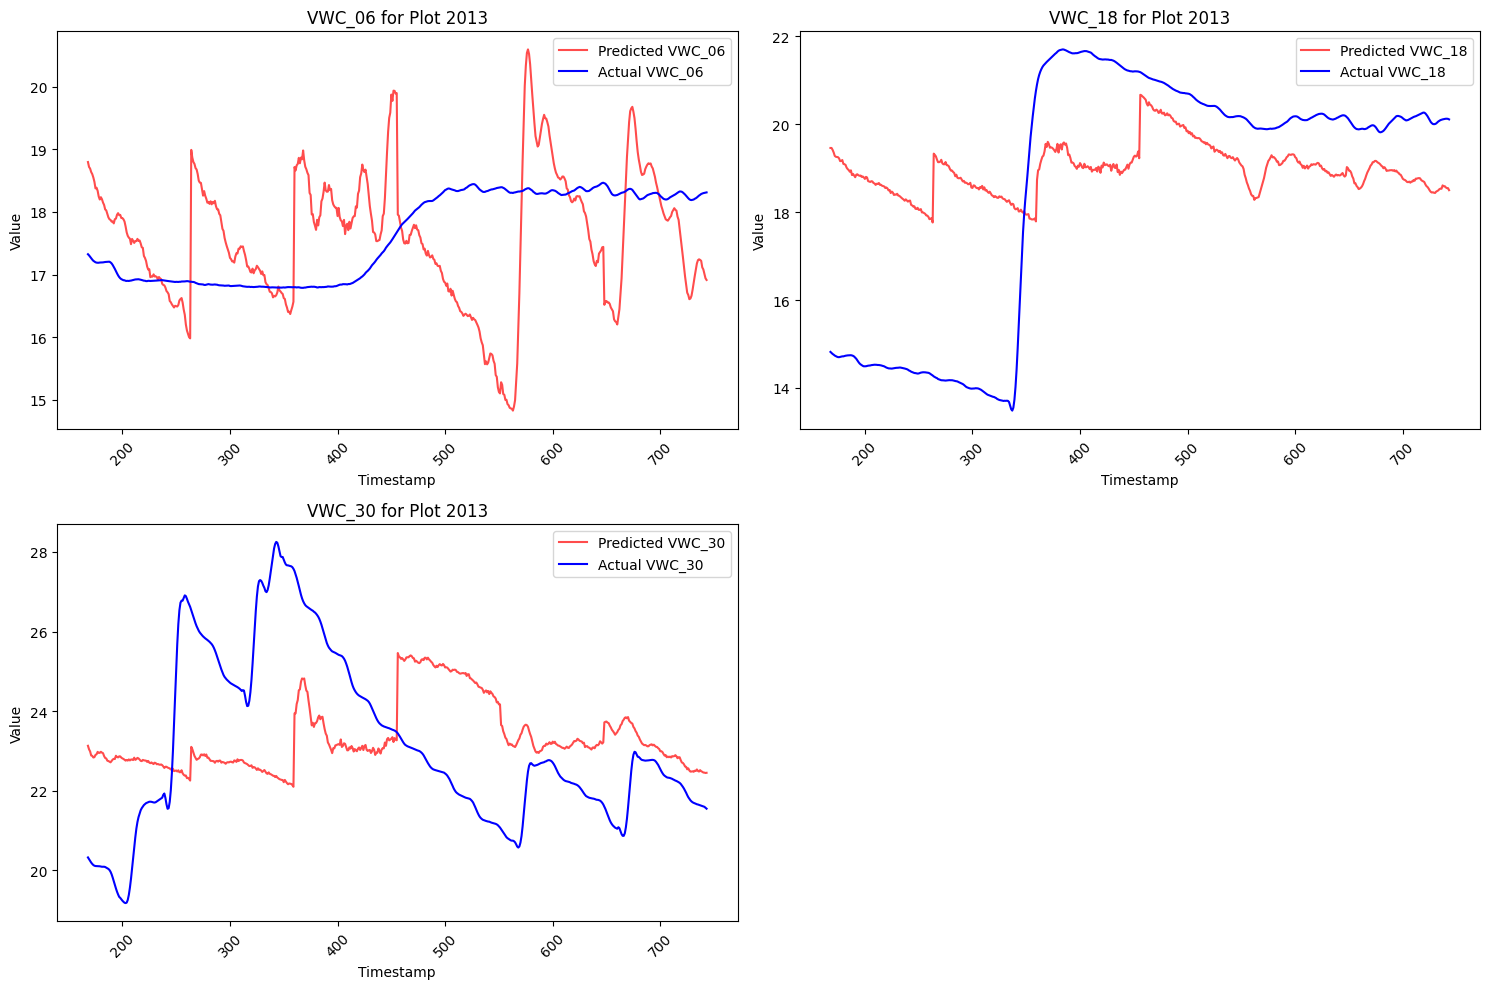

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

def plot_predictions(predictions_df, actuals_df, target_columns, plot_number):
    num_plots = len(target_columns)
    num_rows = int(np.ceil(num_plots / 2))  # You can adjust the number of columns per row if you like
    plt.figure(figsize=(15, 5 * num_rows))  # Adjust the figure size as needed
    for i, column in enumerate(target_columns):
        plt.subplot(num_rows, 2, i + 1)  # Adjust the number of columns per row if you like
        plt.plot(predictions_df.index, predictions_df[column], label=f'Predicted {column}', color='red', alpha=0.7)
        plt.plot(actuals_df.index, actuals_df[column], label=f'Actual {column}', color='blue')
        plt.legend()
        plt.title(f'{column} for Plot {plot_number}')
        plt.xlabel('Timestamp')
        plt.ylabel('Value')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def predict_with_sliding_window(model, df, current_transformation_metadata, target_columns, input_window, forecast_horizon, plot_number):
    # Create input& target data, input data is all columns except target columns
    target_data = df[target_columns].values
    input_data = df.values
    predictions = []
    actuals = []
    timestamps = []
    
    # first iteration flag
    first_iter = True

    # Adjust stride based on prediction: 1 for continuous sliding
    stride = forecast_horizon
    for start in range(0, len(df) - input_window - forecast_horizon + 1, stride):
        end = start + input_window
        if end + forecast_horizon > len(input_data):
            break
        sequence = input_data[start:end]
        sequence = sequence.reshape((1, input_window, len(input_data[0])))

        

        pred = model.predict(sequence)

        
        if first_iter:
            print(f"Sequence shape: {sequence.shape}")
            # To print the top 3 lines, slice the second dimension (sequence length)
            print("Sequence (top 3 lines):")
            print(sequence[0, :3, :])  # Access the first element of the first dimension, then slice
            print(f"Predicted shape: {pred.shape}")
            # Similarly, for the predictions, slice the second dimension
            print("Predicted (top 3 lines):")
            print(pred[0, :3, :])  # Access the first element of the first dimension, then slice
        
            first_iter = False


        pred = pred.reshape(-1, pred.shape[-1])
        predictions.append(pred)
        actuals.append(target_data[end:end + forecast_horizon])
        timestamp_series = pd.Series(df.index[end:end + forecast_horizon], index=df.index[end:end + forecast_horizon])
        timestamps.append(timestamp_series)

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    timestamps = pd.concat(timestamps)

    # Create the DataFrame with the reshaped predictions and the correct timestamps
    predictions_df = pd.DataFrame(predictions, columns=target_columns, index=timestamps)
    actuals_df = pd.DataFrame(actuals, columns=target_columns, index=timestamps)
    
    print(predictions_df.head())

    # Apply reverse transformation and scaling to both predictions and actuals

    # Plot the predictions and actuals before reverse transformation and scaling
    print("Plotting predictions and actuals before reverse transformation and scaling")
    print("Values of predictions_df  and actuals_df before reverse transformation and scaling")
    print(predictions_df.head(3))
    print(actuals_df.head(3))

    plot_predictions(predictions_df, actuals_df, target_columns, plot_number)

    # Apply reverse transformation and scaling to both predictions and actuals
    predictions_df = reverse_transform_and_scale_data(predictions_df, current_transformation_metadata, target_columns)
    actuals_df = reverse_transform_and_scale_data(actuals_df, current_transformation_metadata, target_columns)

    # Example usage
    print("Values of predictions_df  and actuals_df after reverse transformation and scaling")
    print(predictions_df.head(3))
    print(actuals_df.head(3))
    print("Plotting predictions and actuals after reverse transformation and scaling")
    plot_predictions(predictions_df, actuals_df, target_columns, plot_number)

    return predictions_df, actuals_df, timestamps

# Array of plot numbers
plot_numbers = [2013]

# initialize predictions_df and actuals_df and timestamps as empty dataframes
predictions_df = pd.DataFrame()
actuals_df = pd.DataFrame()
timestamps = pd.Series()

# open the transformation metadata file
with open(f"{checkpoint_path}/transformation_metadata1.pkl", "rb") as file:
    transformation_metadata = pickle.load(file)

# initialize scalers from transformation_metadata
scalers = transformation_metadata['scalers']
keep_original_cols = transformation_metadata['keep_original_cols'] 

# Loop through plot numbers
for plot_number in plot_numbers:
    print(f"Processing plot number {plot_number}")
    
    model = tf.keras.models.load_model(checkpoint_path)
    

    df_plot = process_data_for_plot(plot_number)
    
    #drop VWC_40 column if it exists
    if 'VWC_42' in df_plot.columns:
        df_plot = df_plot.drop(columns=['VWC_42'])
        
    # Get the column order and headers from transformation_metadata
    column_order = transformation_metadata['columns']
    column_headers = transformation_metadata['columns']

    # Reorder the columns in the dataframe
    df_plot = df_plot[column_order]
    
    # Reindex the columns
    df_plot.columns = column_headers

    df_plot, current_transform_metadata = transform_and_scale_data(df_plot, target_columns, scalers, keep_original_cols)
    
    # print the means of the transformed data
    print("Means of the transformed data")
    print(df_plot.mean())

    
    predictions_df, actuals_df, timestamps = predict_with_sliding_window(model, df_plot, current_transformation_metadata=current_transform_metadata, 
                                                                         target_columns=target_columns, input_window=24*7, forecast_horizon=96, plot_number=plot_number)


In [ ]:
#print transformed_metadata
print(current_transform_metadata)

{'means': {'VWC_06': 17.820361585349556, 'VWC_18': 18.113769235404764, 'VWC_30': 22.610070112912528}, 'scalers': {'Ta_2m_Avg': MinMaxScaler(), 'RH_2m_Avg': MinMaxScaler(), 'Solar_2m_Avg': MinMaxScaler(), 'WndAveSpd_3m': MinMaxScaler(), 'Dp_2m_Avg': MinMaxScaler(), 'TaMax_2m': MinMaxScaler(), 'TaMin_2m': MinMaxScaler(), 'RHMax_2m': MinMaxScaler(), 'RHMin_2m': MinMaxScaler(), 'HeatIndex_2m_Avg': MinMaxScaler(), 'canopy_temp': MinMaxScaler(), 'VWC_06': MinMaxScaler(), 'VWC_18': MinMaxScaler(), 'VWC_30': MinMaxScaler(), 'daily_et': MinMaxScaler(), 'CWSI': MinMaxScaler(), 'SWSI': MinMaxScaler(), 'precip_irrig': MinMaxScaler(), 'day_sin': MinMaxScaler(), 'day_cos': MinMaxScaler(), 'hour_sin': MinMaxScaler(), 'hour_cos': MinMaxScaler(), 'dow_sin': MinMaxScaler(), 'dow_cos': MinMaxScaler(), 'precip_irrig_log': MinMaxScaler(), 'VWC_06_deriv': MinMaxScaler(), 'VWC_18_deriv': MinMaxScaler(), 'VWC_30_deriv': MinMaxScaler()}, 'keep_original_cols': True, 'initial_values': {}, 'columns': ['Ta_2m_Avg'